[Pandas Yields](#Pandas-Yields)

[Summary Plot](#Summary-plot)

# Fast variable plotter

In [34]:
import pandas as pd
import json
import os
import pyarrow
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import matplotlib.ticker as tck
from sklearn.metrics import roc_auc_score
from IPython.display import HTML, display

#Plot style
plt.style.use('classic')
rcParams['figure.facecolor'] = '1'
rcParams['patch.force_edgecolor'] = False
rcParams['legend.numpoints'] = 1
rcParams['lines.markeredgewidth']=0.0
fpath = os.path.join(rcParams["datapath"], "/nfs/pic.es/user/s/salvador/arial.ttf")
fbipath = os.path.join(rcParams["datapath"], "/nfs/pic.es/user/s/salvador/ArialBoldItalic.ttf")

#Useful functions
def ATLAS(ylims,perc):
    #gets axis coordinates in units of %
    width=ylims[1]-ylims[0]
    return ylims[0]+width*perc
def getlogticks(ticklist):
    #custom format of logarithm log ticks
    aux = [r"10$^{"+str(int(np.log10(i)))+"}$" for i in ticklist]
    return ["1" if x=='10$^{0}$' else "10" if x=='10$^{1}$' else x for x in aux]

from joblib import load, dump
outputdir = "./Plots"
user = "salvador"
pandainput = "pandas_6in_allsig.feather"
reframelep_phi = False
reframelep_eta = False

In [2]:
if not os.path.isdir(outputdir):
    print("Making output dir",outputdir)
    os.makedirs(outputdir, exist_ok=True)
if not os.path.isdir("/tmp/"+user):
    print ("Making tmp dir")
    os.mkdir("/tmp/"+user)

!ls -sh ../HDFWriter

total 9.0G
4.0K CreatePandas.py		    16K pandasconfig.json
4.0K CreatePandas.py~		    16K pandasconfig.json~
824K log			      0 __pycache__
4.0K mini.py~			   4.0K setup.sh
2.4G pandas_6in_allsig.feather	   8.0K tqXData.py
2.4G pandas_6in_allsig_v2.feather  8.0K tqXData.py~
2.1G pandas_6in.feather		   8.0K tqXData.pyc
2.3G pandas_6inv2.feather


In [3]:
!cp /nfs/at3/scratch/salvador/IFAE-tXq/NN/HDFWriter/$pandainput /tmp/$user/

In [3]:
df_mc = pd.read_feather("/tmp/"+user+"/"+pandainput)
print (df_mc.shape)
print (df_mc.columns.unique())

(8593939, 51)
Index(['index', 'jet4_phi_bord', 'jet4_y_bord', 'jet3_m_bord', 'jet2_pt_bord',
       'jet1_eta_bord', 'jet0_eta_bord', 'jet3_btagw_discrete_bord',
       'jet3_pt_bord', 'jet4_m_bord', 'jet1_btagw_discrete_bord', 'lep1_pt',
       'm_jj_leading_jets', 'jet1_phi_bord', 'jet5_eta_bord', 'jet1_pt_bord',
       'jet4_eta_bord', 'jet1_y_bord', 'jet4_btagw_discrete_bord',
       'jet5_y_bord', 'jet0_phi_bord', 'jet2_eta_bord', 'jet2_phi_bord',
       'jet5_btagw_discrete_bord', 'jet3_eta_bord', 'jet0_btagw_discrete_bord',
       'jet0_pt_bord', 'met', 'jet2_y_bord', 'mbb_mindr', 'jet1_m_bord',
       'jet2_m_bord', 'mbb_maxdr', 'lep1_phi', 'lep1_eta', 'jet0_m_bord',
       'jet5_phi_bord', 'jet3_phi_bord', 'jet3_y_bord', 'jet5_pt_bord',
       'mbb_leading_bjets', 'met_phi', 'jet0_y_bord', 'jet5_m_bord',
       'jet2_btagw_discrete_bord', 'jet0_pt', 'jet4_pt_bord', 'weight',
       'process', 'X_mass', 'region'],
      dtype='object')


In [4]:
if reframelep_phi:
    for i in range(0,6):
        df_mc["jet"+str(i)+"_phi_bord"]=df_mc["jet"+str(i)+"_phi_bord"]-df_mc["lep1_phi"]
        df_mc.loc[(df_mc["jet"+str(i)+"_phi_bord"]>np.pi),"jet"+str(i)+"_phi_bord"] -= 2*np.pi
        df_mc.loc[(df_mc["jet"+str(i)+"_phi_bord"]< -np.pi),"jet"+str(i)+"_phi_bord"] += 2*np.pi

    df_mc["met_phi"]=df_mc["met_phi"]-df_mc["lep1_phi"]
    df_mc.loc[(df_mc["met_phi"]>np.pi),"met_phi"] -= 2*np.pi
    df_mc.loc[(df_mc["met_phi"]< -np.pi),"met_phi"] += 2*np.pi
    
    features.remove("lep1_phi")

if reframelep_eta:
    for i in range(0,6):
        df_mc.loc[(df_mc.lep1_eta<0),"jet"+str(i)+"_eta_bord"] *= -1
    df_mc.loc[(df_mc.lep1_eta<0),"lep1_eta"] *= -1

In [6]:
#define list of variables
feature_names = []
for i in range(0,5):
    feature_names+=['jet'+str(i)+'_pt_bord', 'jet'+str(i)+'_eta_bord', 'jet'+str(i)+'_phi_bord', 'jet'+str(i)+'_m_bord', 'jet'+str(i)+'_btagw_discrete_bord']
feature_names+=["lep1_pt","lep1_eta","lep1_phi","met","met_phi"]
feature_names+=["mbb_leading_bjets","mbb_maxdr","mbb_mindr","m_jj_leading_jets"]
print("%5s %20s   %12s   %12s"%("index","Variable","min","max"))
j=0
var_min = []
var_max = []
for i in feature_names:    #Table to save the min and max ranges of variables for the histogram
    var_min.append(df_mc[i].min())
    var_max.append(df_mc[i].max())
    print("%5d %20s   %12.3f   %12.3f"%(j,i,var_min[j],var_max[j]))
    j=j+1

index             Variable            min            max
    0         jet0_pt_bord         25.000       1818.198
    1        jet0_eta_bord         -2.500          2.500
    2        jet0_phi_bord         -3.142          3.142
    3          jet0_m_bord          0.014        216.307
    4 jet0_btagw_discrete_bord          4.310          4.565
    5         jet1_pt_bord         25.000       2058.654
    6        jet1_eta_bord         -2.500          2.500
    7        jet1_phi_bord         -3.142          3.142
    8          jet1_m_bord         -0.196        292.472
    9 jet1_btagw_discrete_bord          4.310          4.565
   10         jet2_pt_bord         25.000       1926.686
   11        jet2_eta_bord         -2.500          2.500
   12        jet2_phi_bord         -3.142          3.142
   13          jet2_m_bord         -0.064        322.061
   14 jet2_btagw_discrete_bord          3.905          4.565
   15         jet3_pt_bord         25.000       2126.193
   16        jet3_e

In [27]:
#####Single plotter
imass = 125
region = "all"
variablename = "mbb_leading_bjets"
i = feature_names.index(variablename)
#i = 3
print(i,feature_names[i])
logy = True
signal = True

#definition of regions
regions = ['all','c1l4jex3bex', 'c1l4jex4bin', 'c1l5jex3bex', 'c1l5jex4bin','c1l6jex3bex','c1l6jex4bin']
labelsreg = {'all': "Inclusive","c1l6jin4bin": r'$\geq$6j$\geq$4b',"c1l6jin3bex": r'$\geq$6j'+" 3b","c1l6jex4bin": r'6j$\geq$4b',"c1l6jex3bex": "6j 3b", "c1l5jex4bin": "5j "+r'$\geq$'+"4b","c1l5jex3bex":"5j 3b","c1l4jex4bin": r'4j$\geq$4b',"c1l4jex3bex": "4j 3b"}

#Define masks for signal
issignalmsk = (df_mc.X_mass==imass)       
uXmsk = (df_mc.process=="uX_"+str(imass))            
ubXmsk = (df_mc.process=="ubarX_"+str(imass))            
cXmsk = (df_mc.process=="cX_"+str(imass))            
cbXmsk = (df_mc.process=="cbarX_"+str(imass))
#Define samples to plot (list for grouped), color and legend label
samples = ['ttbarlight','ttc','ttb',['Wtocb', 'Singletop', 'topEW', 'ttH','Dibosons']]
samples.reverse() #reverse it to plot from bottom to top in stacked plot
colors = ["palegreen","royalblue","lightsteelblue","ghostwhite"]
labels = [r'$t\bar{t} + light$',r'$t\bar{t} + \geq1c$',r'$t\bar{t} + \geq1b$',r'$other$']
labels.reverse()
datasets = [] #obtain the background 
for isamp in samples:
    if type(isamp)!=type(datasets):
        datasets.append(df_mc[df_mc.process==isamp])
    else:
        joiner = [df_mc[df_mc.process==j] for j in isamp]
        datasets.append(pd.concat(joiner))
        
signalmsk2=(uXmsk | ubXmsk)
signalleg2 = r"$tuH$"
        
signalmsk=(cXmsk | cbXmsk)
signalleg = "$tcH$"

30 mbb_leading_bjets


[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05 1.e+06]


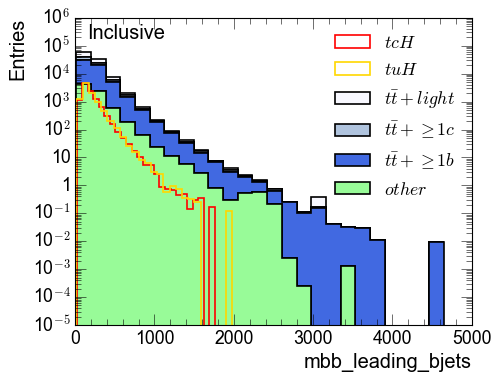

In [28]:
#Plotting, this could be just a function... Ideal for tests
plt.figure(figsize=(6.4,4.8),linewidth=0)
ypos = 0.95

if region!="all":
    if signal: 
        plt.hist(df_mc[(signalmsk) & (regionmsk)][feature_names[i]],bins=25,weights=df_mc[(signalmsk) & (regionmsk)].weight,label=signalleg, color="r",linewidth=1.5,stacked=True,ec="r",histtype="step")
        plt.hist(df_mc[(signalmsk2) & (regionmsk)][feature_names[i]],bins=25,weights=df_mc[(signalmsk2) & (regionmsk)].weight,label=signalleg2, color="gold",linewidth=1.5,stacked=True,ec="gold",histtype="step")
    plt.hist([ipd[ipd.region==region][feature_names[i]] for ipd in datasets],bins=25,weights=[ipd[ipd.region==region].weight for ipd in datasets],label=labels, color=colors,stacked=True,ec="k",linewidth=1.5,histtype="stepfilled")
else:
    if signal:
        plt.hist(df_mc[signalmsk][feature_names[i]],bins=25,weights=df_mc[signalmsk].weight,label=signalleg, color="r",linewidth=1.5,stacked=True,ec="r",histtype="step")
        plt.hist(df_mc[signalmsk2][feature_names[i]],bins=25,weights=df_mc[signalmsk2].weight,label=signalleg2, color="gold",linewidth=1.5,stacked=True,ec="gold",histtype="step")
    plt.hist([ipd[feature_names[i]] for ipd in datasets],bins=25,weights=[ipd.weight for ipd in datasets],label=labels, color=colors,stacked=True,ec="k",linewidth=1.5,histtype="stepfilled")
    
#axis legends adjusted to edge and change of font
plt.xlabel(feature_names[i],horizontalalignment='right',x=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
plt.ylabel("Entries",horizontalalignment='right',y=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
if logy:
    plt.yscale("log")
    ypos = 0.6
else:
    plt.ylim(0,plt.gca().get_ylim()[1]*1.25) #make the y range 25% higher and start from 0
plt.gca().set_xticks(plt.gca().get_xticks().tolist()) #to control matplotlib errors
plt.gca().set_yticks(plt.gca().get_yticks().tolist())
plt.gca().set_xticklabels([int(num) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=16)) #Format the labels of the ticks
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator()) #Plot more minor ticks

if logy: #if logy plot, need to obtain the 10^ format and minor ticks 
    print(plt.gca().get_yticks())
    plt.gca().set_yticklabels(getlogticks(plt.gca().get_yticks()), fontproperties=fm.FontProperties(fname=fpath,size=16))
    plt.gca().yaxis.set_minor_locator(tck.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
else:
    plt.gca().set_yticklabels([int(num) for num in plt.gca().get_yticks()], fontproperties=fm.FontProperties(fname=fpath,size=16))
    plt.gca().yaxis.set_minor_locator(tck.AutoMinorLocator())
    
plt.gca().tick_params(length=10, width=0.5) #Longer ticks
plt.gca().tick_params(which="minor",length=5, width=0.5)

#To print some text in % position of the axes
plt.text(ATLAS(plt.gca().get_xlim(),0.03),ATLAS(plt.gca().get_ylim(),ypos),labelsreg[region],va='top',ha='left',fontproperties=fm.FontProperties(fname=fpath,size=18))

plt.legend(loc="upper right",prop=fm.FontProperties(fname=fpath,size=16),frameon=False)
plt.show()

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


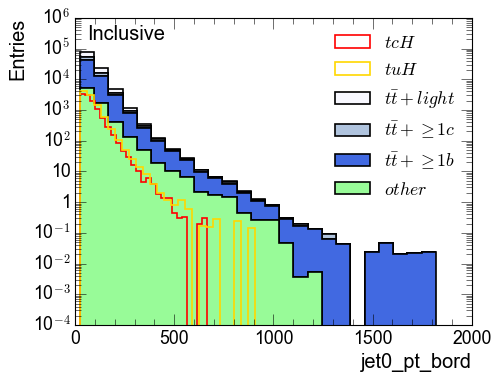

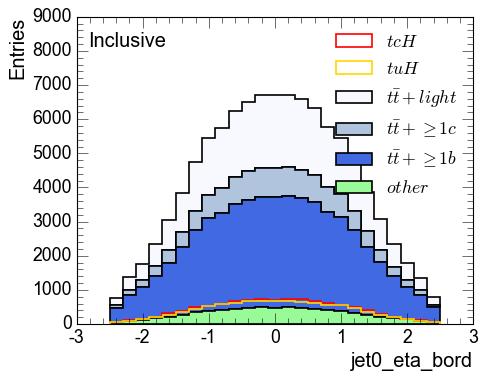

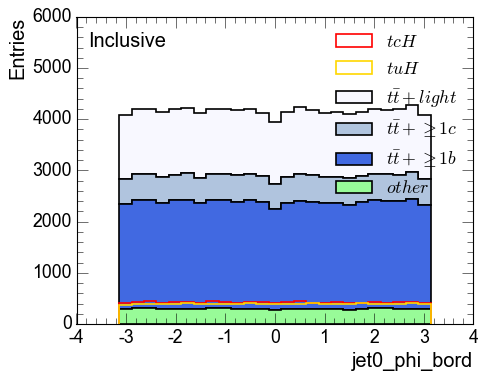

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


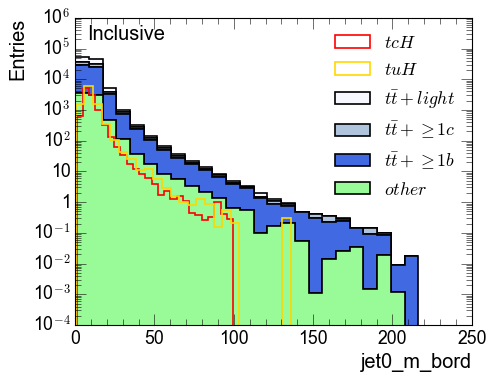

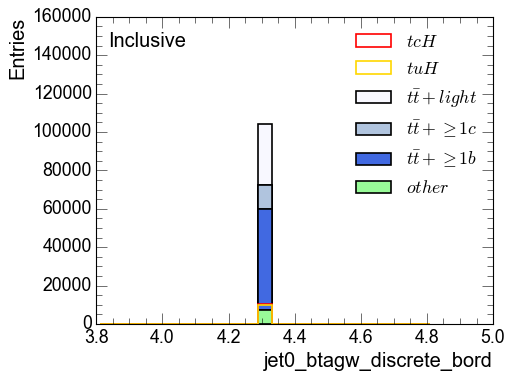

[1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03
 1.e+04 1.e+05 1.e+06]


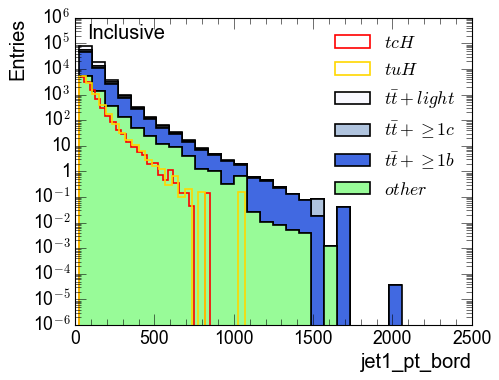

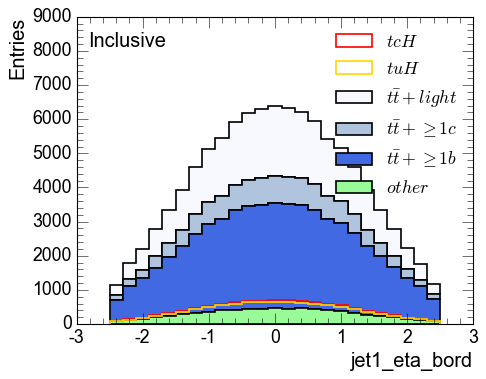

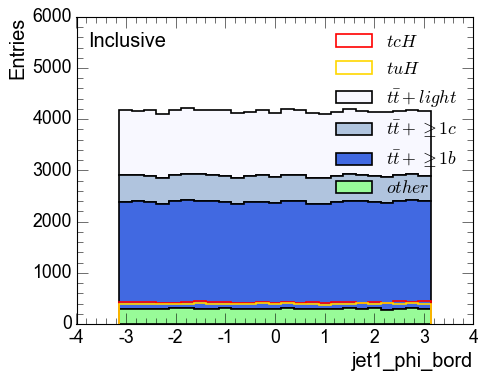

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


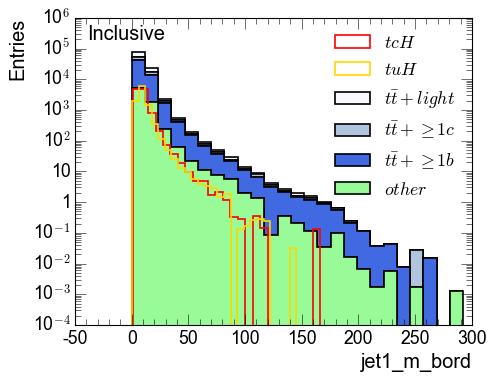

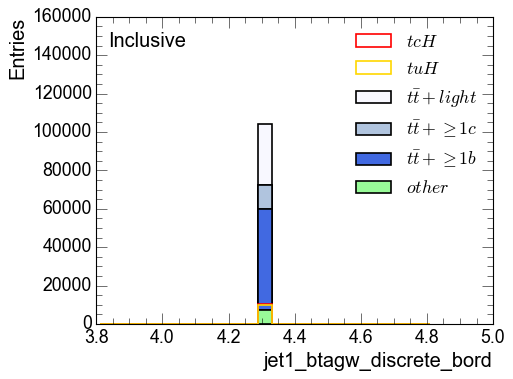

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


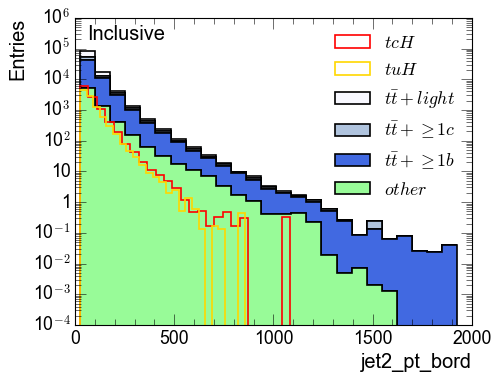

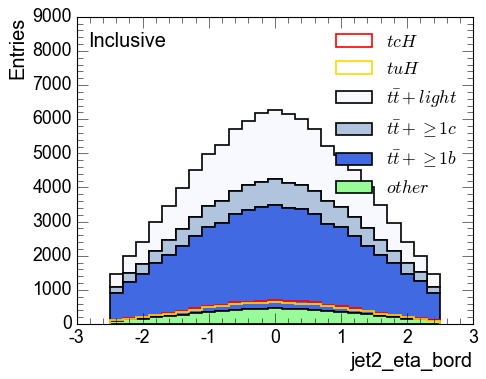

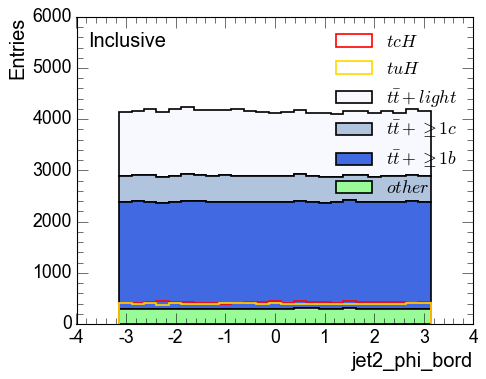

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05 1.e+06]


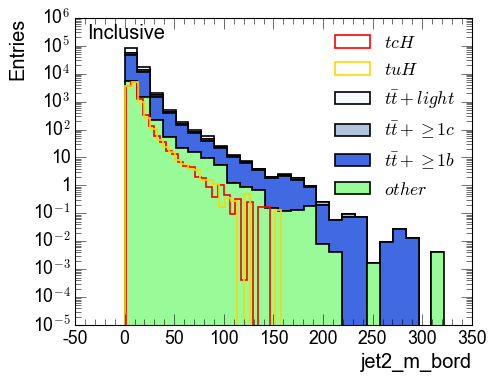

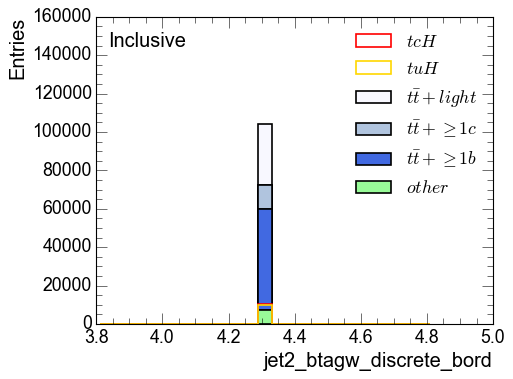

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


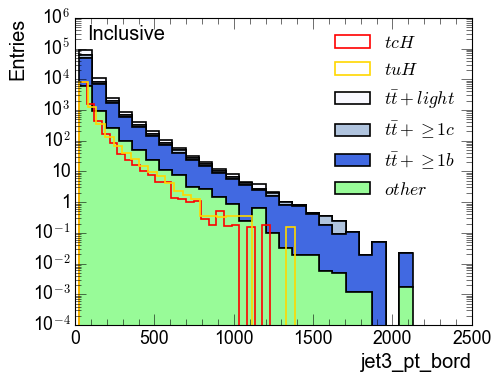

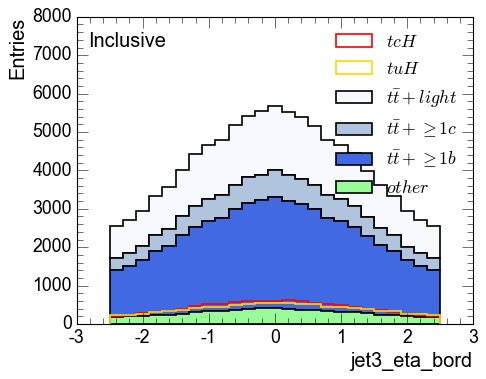

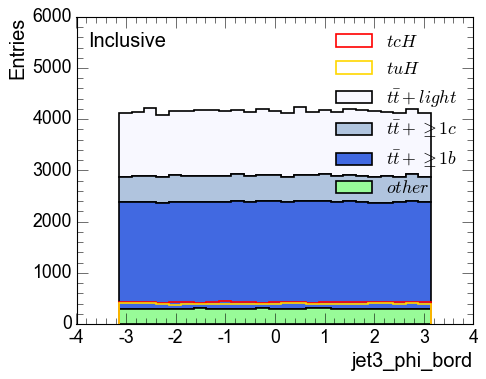

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


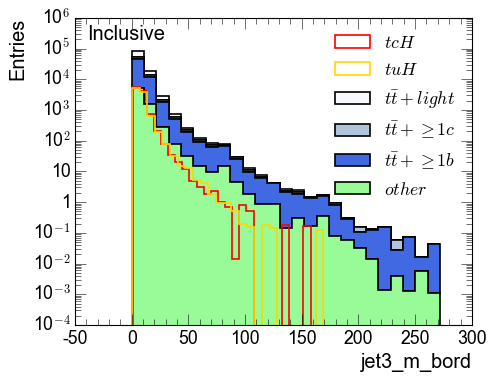

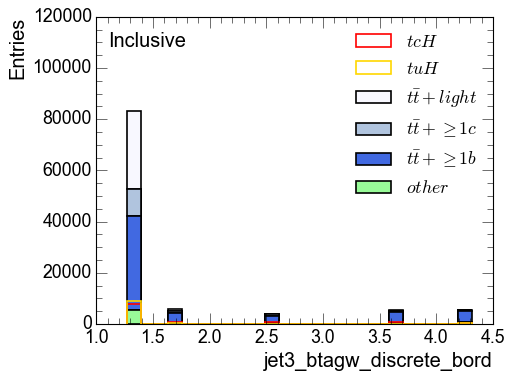

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


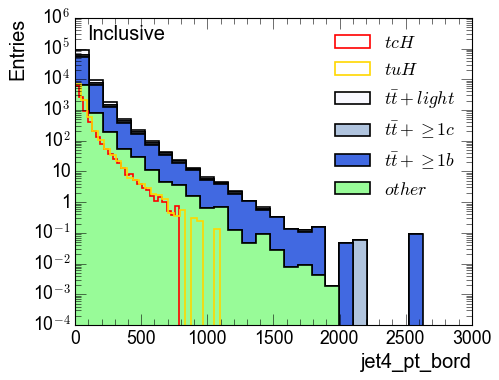

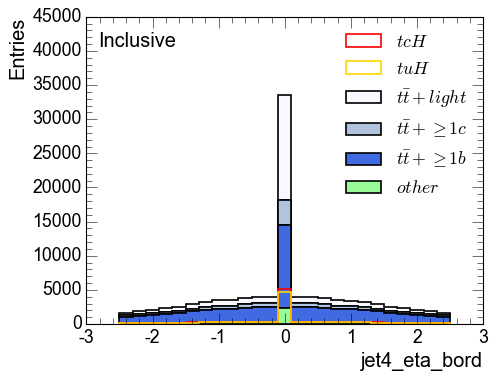

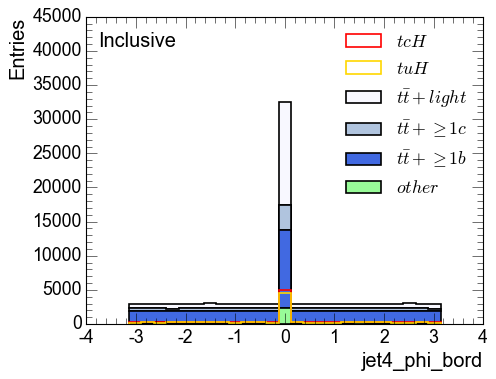

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


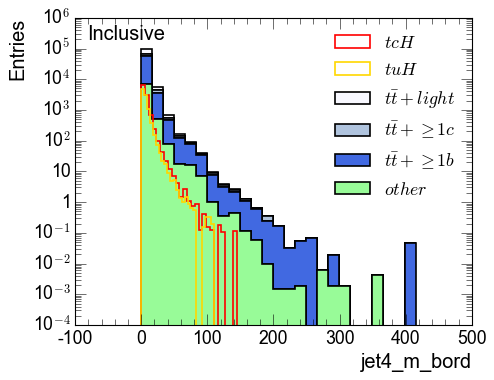

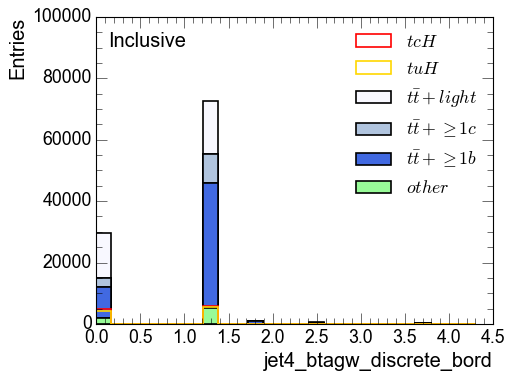

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05 1.e+06 1.e+07]


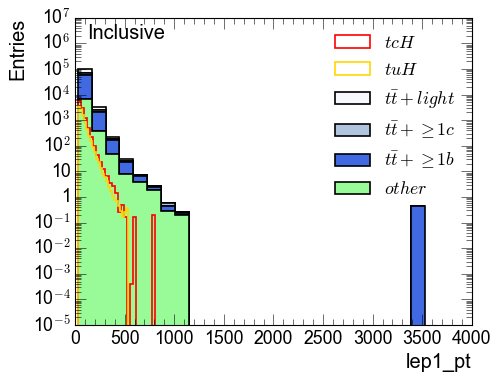

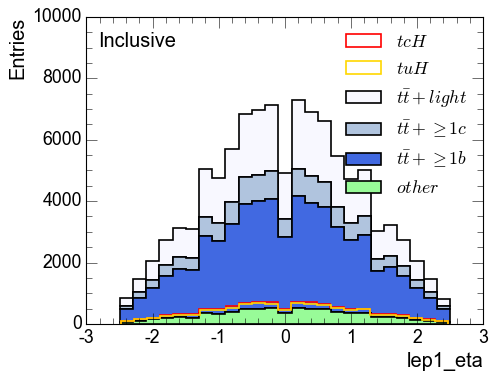

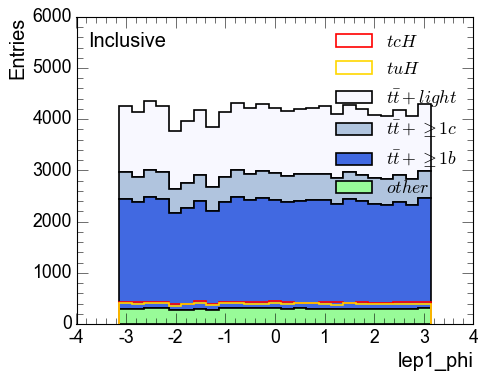

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05
 1.e+06]


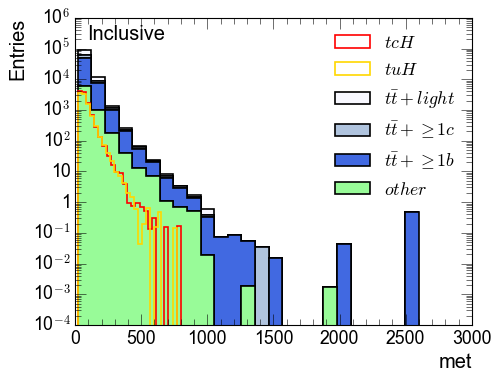

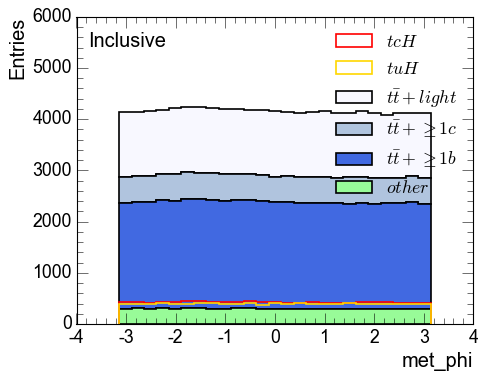

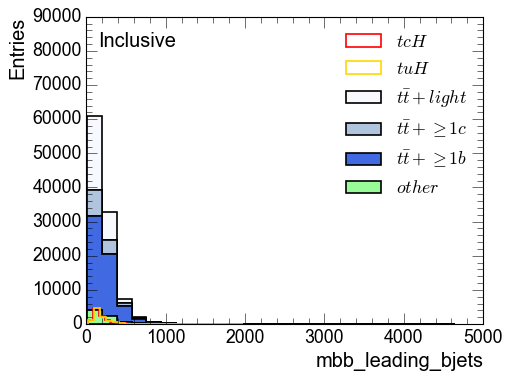

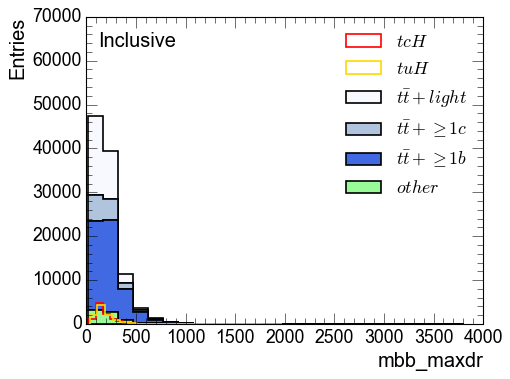

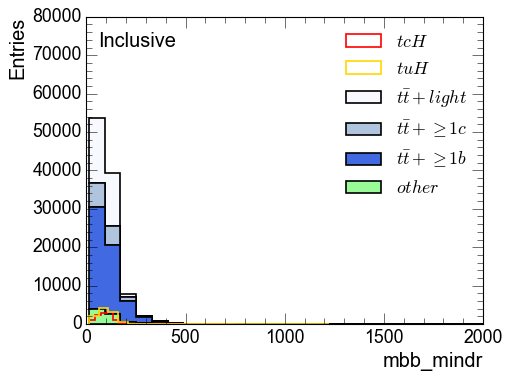

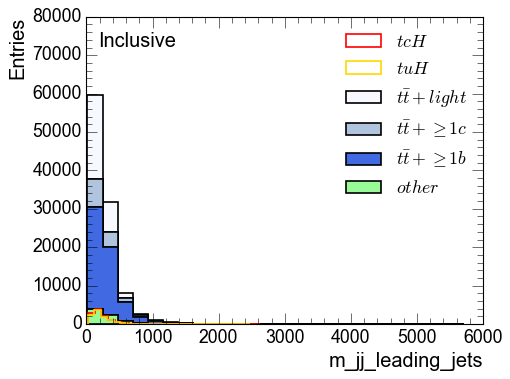

In [31]:
#### Multiple variable plotter

signal = True
imass = 125
region = "all"
logyvariables = [0,3,5,8,10,13,15,18,20,23,25,28] #index of variables to do log

regions = ['all','c1l4jex3bex', 'c1l4jex4bin', 'c1l5jex3bex', 'c1l5jex4bin','c1l6jex3bex','c1l6jex4bin']
labelsreg = {'all': "Inclusive","c1l6jin4bin": r'$\geq$6j$\geq$4b',"c1l6jin3bex": r'$\geq$6j'+" 3b","c1l6jex4bin": r'6j$\geq$4b',"c1l6jex3bex": "6j 3b", "c1l5jex4bin": "5j "+r'$\geq$'+"4b","c1l5jex3bex":"5j 3b","c1l4jex4bin": r'4j$\geq$4b',"c1l4jex3bex": "4j 3b"}

issignalmsk = (df_mc.X_mass==imass)       
uXmsk = (df_mc.process=="uX_"+str(imass))            
ubXmsk = (df_mc.process=="ubarX_"+str(imass))            
cXmsk = (df_mc.process=="cX_"+str(imass))            
cbXmsk = (df_mc.process=="cbarX_"+str(imass))

samples = ['ttbarlight','ttc','ttb',['Wtocb', 'Singletop', 'topEW', 'ttH','Dibosons']]
samples.reverse()
colors = ["palegreen","royalblue","lightsteelblue","ghostwhite"]
labels = [r'$t\bar{t} + light$',r'$t\bar{t} + \geq1c$',r'$t\bar{t} + \geq1b$',r'$other$']
labels.reverse()
datasets = []
for i in samples:
    if type(i)!=type(datasets):
        datasets.append(df_mc[df_mc.process==i])
    else:
        joiner = [df_mc[df_mc.process==j] for j in i]
        datasets.append(pd.concat(joiner))
        
signalmsk2=(uXmsk | ubXmsk)
signalleg2 = r"$tuH$"
        
signalmsk=(cXmsk | cbXmsk)
signalleg = "$tcH$"
regionmsk = (df_mc.region==region)
for i in range(len(feature_names)):
    ypos = 0.95
    if i in logyvariables: logy = True
    else: logy = False
    plt.figure(figsize=(6.4,4.8),linewidth=0)
    if region!="all":
        if signal:
            plt.hist(df_mc[(signalmsk) & (regionmsk)][feature_names[i]],bins=25,weights=df_mc[(signalmsk) & (regionmsk)].weight,label=signalleg, color="r",linewidth=1.5,stacked=True,ec="r",histtype="step")
            plt.hist(df_mc[(signalmsk2) & (regionmsk)][feature_names[i]],bins=25,weights=df_mc[(signalmsk2) & (regionmsk)].weight,label=signalleg2, color="gold",linewidth=1.5,stacked=True,ec="gold",histtype="step")
        plt.hist([ipd[ipd.region==region][feature_names[i]] for ipd in datasets],bins=25,weights=[ipd[ipd.region==region].weight for ipd in datasets],label=labels, color=colors,stacked=True,ec="k",linewidth=1.5,histtype="stepfilled")
    else:
        if signal:
            plt.hist(df_mc[signalmsk][feature_names[i]],bins=25,weights=df_mc[signalmsk].weight,label=signalleg, color="r",linewidth=1.5,stacked=True,ec="r",histtype="step")
            plt.hist(df_mc[signalmsk2][feature_names[i]],bins=25,weights=df_mc[signalmsk2].weight,label=signalleg2, color="gold",linewidth=1.5,stacked=True,ec="gold",histtype="step")
        plt.hist([ipd[feature_names[i]] for ipd in datasets],bins=25,weights=[ipd.weight for ipd in datasets],label=labels, color=colors,stacked=True,ec="k",linewidth=1.5,histtype="stepfilled")
    plt.xlabel(feature_names[i],horizontalalignment='right',x=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
    plt.ylabel("Entries",horizontalalignment='right',y=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
    if logy:
        plt.yscale("log")
        ypos = 0.6
    else:
        plt.ylim(0,plt.gca().get_ylim()[1]*1.25)
    plt.gca().set_xticks(plt.gca().get_xticks().tolist())
    plt.gca().set_yticks(plt.gca().get_yticks().tolist())
    if "btagw_discrete" not in feature_names[i]:
        plt.gca().set_xticklabels([int(num) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=16))
    else: 
        plt.gca().set_xticklabels([round(num,2) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=16))
    plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())

    if logy:
        print(plt.gca().get_yticks())
        plt.gca().set_yticklabels(getlogticks(plt.gca().get_yticks()), fontproperties=fm.FontProperties(fname=fpath,size=16))
        plt.gca().yaxis.set_minor_locator(tck.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
    else:
        plt.gca().set_yticklabels([int(num) for num in plt.gca().get_yticks()], fontproperties=fm.FontProperties(fname=fpath,size=16))
        plt.gca().yaxis.set_minor_locator(tck.AutoMinorLocator())
    
    plt.text(ATLAS(plt.gca().get_xlim(),0.03),ATLAS(plt.gca().get_ylim(),ypos),labelsreg[region],va='top',ha='left',fontproperties=fm.FontProperties(fname=fpath,size=18))
    plt.gca().tick_params(length=10, width=0.5)
    plt.gca().tick_params(which="minor",length=5, width=0.5)
    plt.legend(loc="upper right",prop=fm.FontProperties(fname=fpath,size=16),frameon=False)
    plt.show()

# Pandas Yields

In [32]:
#To extract yields in a very nice format. Takes a while!
masses = [20,30,40,50,60,70,80,90,100,120,125,140,160]
issignalmsk = (df_mc.X_mass>=0)       
processes = ['ttbarlight', 'ttc', 'ttb', 'Wtocb', 'Singletop', 'topEW', 'ttH','Dibosons']
signals = ['uX_', 'ubarX_', 'cX_', 'cbarX_']
regions = ['c1l4jex3bex', 'c1l4jex4bin', 'c1l5jex3bex', 'c1l5jex4bin','c1l6jin3bex','c1l6jin4bin']
regions.reverse()
table="<table><tr><td>Sample</td>"
table+="<td>6jin4bin</td>"
table+="<td>6jin3bex</td>"
table+="<td>5jex4bin</td>"
table+="<td>5jex3bex</td>"
table+="<td>4jex4bin</td>"
table+="<td>4jex3bex</td></tr>"
B = {}
for iproc in processes:
    print (iproc)
    table+="<tr>"
    table+="<td>"+iproc+"</td>"
    for ireg in regions:
        table+="<td>"+str(round(df_mc[ (df_mc.process==iproc) & (df_mc.region==ireg) ].weight.sum(),4)) +"</td>"
    table+="</tr>"
table+="<tr><td>Tot. bkg</td>"
for ireg in regions:
    B[ireg] = df_mc[(~issignalmsk) & (df_mc.region==ireg)].weight.sum()
    table+="<td>"+str(round(B[ireg],4))+"</td>"
table+="</tr>"

for mass in masses:
    print(mass)
    uXmsk = (df_mc.process=="uX_"+str(mass))            
    ubXmsk = (df_mc.process=="ubarX_"+str(mass))            
    cXmsk = (df_mc.process=="cX_"+str(mass))            
    cbXmsk = (df_mc.process=="cbarX_"+str(mass))
    for proc in signals:
        iproc = proc+str(mass)
        table+="<tr>"
        table+="<td>"+iproc+"</td>"
        for ireg in regions:
            table+="<td>"+str(round(df_mc[ (df_mc.process==iproc) & (df_mc.region==ireg) ].weight.sum(),4)) +"</td>"
        table+="</tr>"
        table+="<tr>"
        table+="<td>"+iproc+" sig</td>"
        for ireg in regions:
            table+="<td>"+str(round(df_mc[ (df_mc.process==iproc) & (df_mc.region==ireg) ].weight.sum()/np.sqrt(B[ireg]),4)) +"</td>"
        table+="</tr>"
        table+="<td>"+iproc+" S/B</td>"
        for ireg in regions:
            table+="<td>"+str(round(df_mc[ (df_mc.process==iproc) & (df_mc.region==ireg) ].weight.sum()/(B[ireg]),4)) +"</td>"
        table+="</tr>"
    table+="<tr><td>uX "+str(mass)+"</td>"
    for ireg in regions:
        table+="<td>"+str(round(df_mc[ (df_mc.region==ireg) & ((uXmsk) | (ubXmsk))].weight.sum(),4))+"</td>"
    table+="</tr>"
    table+="<tr><td>uX "+str(mass)+" sig</td>"
    for ireg in regions:
        table+="<td>"+str(round(df_mc[ (df_mc.region==ireg) & ((uXmsk) | (ubXmsk))].weight.sum()/np.sqrt(B[ireg]),4))+"</td>"
    table+="</tr>"
    table+="<tr><td>uX "+str(mass)+" S/B</td>"
    for ireg in regions:
        table+="<td>"+str(round(df_mc[ (df_mc.region==ireg) & ((uXmsk) | (ubXmsk))].weight.sum()/(B[ireg]),4))+"</td>"
    table+="</tr>"
    table+="<tr><td>cX "+str(mass)+"</td>"
    for ireg in regions:
        table+="<td>"+str(round(df_mc[ (df_mc.region==ireg) & ((cXmsk) | (cbXmsk))].weight.sum(),4))+"</td>"
    table+="</tr>"
    table+="<tr><td>cX "+str(mass)+" sig</td>"
    for ireg in regions:
        table+="<td>"+str(round(df_mc[ (df_mc.region==ireg) & ((cXmsk) | (cbXmsk))].weight.sum()/np.sqrt(B[ireg]),4))+"</td>"
    table+="</tr>"
    table+="<tr><td>cX "+str(mass)+" S/B</td>"
    for ireg in regions:
        table+="<td>"+str(round(df_mc[ (df_mc.region==ireg) & ((cXmsk) | (cbXmsk))].weight.sum()/(B[ireg]),4))+"</td>"
    table+="</tr>"
table+="<table>"
display(HTML(table))


ttbarlight
ttc
ttb
Wtocb
Singletop
topEW
ttH
Dibosons
20
30
40
50
60
70
80
90
100
120
125
140
160


Sample,6jin4bin,6jin3bex,5jex4bin,5jex3bex,4jex4bin,4jex3bex
ttbarlight,17.0079,7041.8481,13.0995,10103.9771,8.1356,14413.3591
ttc,82.1912,5327.9882,40.3576,4120.0197,16.8855,3177.9737
ttb,3301.3312,23236.386,997.6442,14885.0545,287.9321,9516.4303
Wtocb,16.6315,206.8774,12.2515,266.4662,9.4576,356.4639
Singletop,113.2934,1116.0798,49.3266,1224.3287,25.317,1378.8207
topEW,97.4258,469.9883,25.8891,197.2137,6.0127,98.7429
ttH,217.7429,740.0831,50.0617,286.4826,7.2083,108.5662
Dibosons,9.248,111.7021,5.1737,97.1411,5.3051,102.9514
Tot. bkg,3854.8718,38250.9529,1193.8038,31180.6834,366.2539,29153.3083
uX_20,22.8855,242.4644,9.1534,270.9272,0.9214,307.0366


# Summary plot

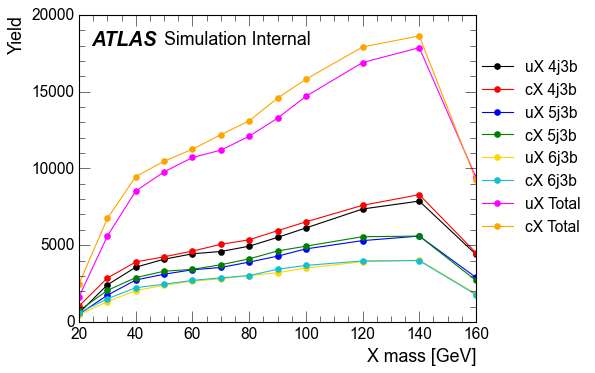

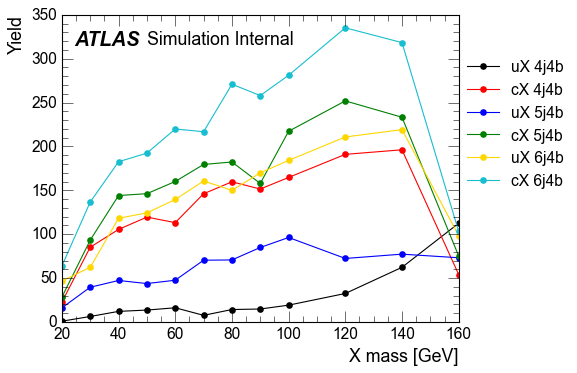

In [37]:
samples = ['ttbarlight','ttc','ttb',['Wtocb', 'Singletop', 'topEW', 'ttH','Dibosons']]
colors = ["palegreen","royalblue","lightsteelblue","ghostwhite"]
labels = [r'$t\bar{t} + light$',r'$t\bar{t} + \geq1c$',r'$t\bar{t} + \geq1b$',r'$other$']
regions = ['c1l4jex3bex', 'c1l4jex4bin', 'c1l5jex3bex', 'c1l5jex4bin','c1l6jin3bex','c1l6jin4bin']
labelsreg = {'all': "Inclusive","c1l6jin4bin": r'$\geq$6j$\geq$4b',"c1l6jin3bex": r'$\geq$6j'+" 3b","c1l6jex4bin": r'6j$\geq$4b',"c1l6jex3bex": "6j 3b", "c1l5jex4bin": "5j "+r'$\geq$'+"4b","c1l5jex3bex":"5j 3b","c1l4jex4bin": r'4j$\geq$4b',"c1l4jex3bex": "4j 3b"}
#each column is a region. Would be nice to do a proper pandas and store it 
#extracting all these numbers takes a while
numbers = {
"Tot. bkg":[3854.9,38251.0,1193.8,31180.7,366.3,29153.3],
"uX 20":[46.6,481.6,16.1,512.4,0.9,597.8],
"cX 20":[63.8,602.7,28.3,739.2,22.7,1048.0],
"uX 30":[62.3,1333.2,39.6,1745.6,6.3,2422.3],
"cX 30":[136.7,1511.9,93.3,2060.6,85.2,2867.1],
"uX 40":[118.2,2045.4,47.3,2736.0,12.1,3569.8],
"cX 40":[182.6,2234.5,144.1,2887.8,105.5,3909.8],
"uX 50":[124.3,2394.0,43.8,3113.3,13.6,4087.8],
"cX 50":[192.4,2462.3,146.2,3306.8,119.5,4245.2],
"uX 60":[139.6,2666.1,47.6,3399.2,16.2,4441.7],
"cX 60":[219.9,2708.3,160.1,3426.5,113.2,4617.1],
"uX 70":[160.6,2809.4,70.4,3548.6,7.6,4589.2],
"cX 70":[216.8,2873.4,179.5,3726.0,146.1,5055.4],
"uX 80":[150.0,3020.5,70.7,3901.7,14.2,4935.5],
"cX 80":[270.9,3022.3,182.3,4109.9,159.7,5352.1],
"uX 90":[169.9,3204.7,84.9,4285.5,14.8,5506.9],
"cX 90":[258.0,3437.4,157.9,4623.8,151.5,5944.0],
"uX 100":[184.1,3513.3,96.3,4758.7,19.2,6122.1],
"cX 100":[281.1,3683.0,217.3,4937.9,164.7,6518.7],
"uX 120":[210.8,3921.7,72.4,5297.9,32.5,7355.9],
"cX 120":[335.2,3977.2,251.9,5552.3,191.0,7595.9],
"uX 125":[117.5,2193.3,61.0,3130.7,23.6,4354.9],
"cX 125":[163.0,2274.7,136.5,3296.3,116.4,4652.1],
"uX 140":[219.2,4033.3,77.3,5594.6,62.3,7872.3],
"cX 140":[318.3,3995.0,233.3,5592.9,196.2,8289.5],
"uX 160":[98.4,1833.4,73.2,2901.7,112.5,4402.9],
"cX 160":[103.2,1782.0,75.2,2706.5,54.1,4507.7]
        }

masses = [20,30,40,50,60,70,80,90,100,120,140,160]
colors = ["black","red","blue","green","gold","tab:cyan","magenta","orange"]

#Separated plot in 3b and 4b regions
plt.figure(figsize=(6.4,4.8),linewidth=0)
plt.plot(masses,[numbers["uX "+str(imass)][5] for imass in masses ],"-o",color=colors[0],label="uX 4j3b")
plt.plot(masses,[numbers["cX "+str(imass)][5] for imass in masses ],"-o",color=colors[1],label="cX 4j3b")
plt.plot(masses,[numbers["uX "+str(imass)][3] for imass in masses ],"-o",color=colors[2],label="uX 5j3b")
plt.plot(masses,[numbers["cX "+str(imass)][3] for imass in masses ],"-o",color=colors[3],label="cX 5j3b")
plt.plot(masses,[numbers["uX "+str(imass)][1] for imass in masses ],"-o",color=colors[4],label="uX 6j3b")
plt.plot(masses,[numbers["cX "+str(imass)][1] for imass in masses ],"-o",color=colors[5],label="cX 6j3b")

plt.plot(masses,[sum(numbers["uX "+str(imass)]) for imass in masses ],"-o",color=colors[6],label="uX Total") 
plt.plot(masses,[sum(numbers["cX "+str(imass)]) for imass in masses ],"-o",color=colors[7],label="cX Total") 

plt.xlabel(r"X mass [GeV]",horizontalalignment='right',x=1,fontproperties=fm.FontProperties(fname=fpath,size=16))
plt.ylabel(r'Yield',horizontalalignment='right',y=1,fontproperties=fm.FontProperties(fname=fpath,size=16))

plt.gca().set_xticks(plt.gca().get_xticks().tolist()) #to control matplotlib errors
plt.gca().set_yticks(plt.gca().get_yticks().tolist())
plt.gca().set_xticklabels([int(num) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=14))
plt.gca().set_yticklabels([int(num) for num in plt.gca().get_yticks()], fontproperties=fm.FontProperties(fname=fpath,size=14))
plt.gca().yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.gca().tick_params(length=10, width=0.5)
plt.gca().tick_params(which="minor",length=5, width=0.5)
plt.text(ATLAS(plt.gca().get_xlim(),0.03),ATLAS(plt.gca().get_ylim(),0.95),"ATLAS",va='top',ha='left',fontproperties=fm.FontProperties(fname=fbipath,size=18))
plt.text(ATLAS(plt.gca().get_xlim(),0.03),ATLAS(plt.gca().get_ylim(),0.95),"               Simulation Internal",va='top',ha='left',fontproperties=fm.FontProperties(fname=fpath,size=16))

#personalized coordinates
plt.legend(bbox_to_anchor=(1.30,0.9),prop=fm.FontProperties(fname=fpath,size=14),frameon=False)

plt.savefig("plot3bregtot.png",dpi=300,bbox_inches='tight')
plt.show()

#Second plot
plt.figure(figsize=(6.4,4.8),linewidth=0)
plt.plot(masses,[numbers["uX "+str(imass)][4] for imass in masses ],"-o",color=colors[0],label="uX 4j4b")
plt.plot(masses,[numbers["cX "+str(imass)][4] for imass in masses ],"-o",color=colors[1],label="cX 4j4b")
plt.plot(masses,[numbers["uX "+str(imass)][2] for imass in masses ],"-o",color=colors[2],label="uX 5j4b")
plt.plot(masses,[numbers["cX "+str(imass)][2] for imass in masses ],"-o",color=colors[3],label="cX 5j4b")
plt.plot(masses,[numbers["uX "+str(imass)][0] for imass in masses ],"-o",color=colors[4],label="uX 6j4b")
plt.plot(masses,[numbers["cX "+str(imass)][0] for imass in masses ],"-o",color=colors[5],label="cX 6j4b")

plt.xlabel(r"X mass [GeV]",horizontalalignment='right',x=1,fontproperties=fm.FontProperties(fname=fpath,size=16))
plt.ylabel(r'Yield',horizontalalignment='right',y=1,fontproperties=fm.FontProperties(fname=fpath,size=16))
plt.gca().set_xticks(plt.gca().get_xticks().tolist()) #to control matplotlib errors
plt.gca().set_yticks(plt.gca().get_yticks().tolist())
plt.gca().set_xticklabels([int(num) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=14))
plt.gca().set_yticklabels([int(num) for num in plt.gca().get_yticks()], fontproperties=fm.FontProperties(fname=fpath,size=14))
plt.gca().yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.gca().tick_params(length=10, width=0.5)
plt.gca().tick_params(which="minor",length=5, width=0.5)
plt.text(ATLAS(plt.gca().get_xlim(),0.03),ATLAS(plt.gca().get_ylim(),0.95),"ATLAS",va='top',ha='left',fontproperties=fm.FontProperties(fname=fbipath,size=18))
plt.text(ATLAS(plt.gca().get_xlim(),0.03),ATLAS(plt.gca().get_ylim(),0.95),"               Simulation Internal",va='top',ha='left',fontproperties=fm.FontProperties(fname=fpath,size=16))

plt.legend(bbox_to_anchor=(1.30,0.9),prop=fm.FontProperties(fname=fpath,size=14),frameon=False)

plt.savefig("plot4breg.png",dpi=300,bbox_inches='tight')
plt.show()